## Experiment Setup

###  Random seed / PyTorch / Colab / CUDA related

In [1]:
import torch
import numpy as np

# Google Colab-only setup.
use_colab = True

# Is this running on Colab?
import importlib
colab_available = importlib.util.find_spec("google.colab") is not None

if use_colab and colab_available:
    # Mount my Google Drive root folder
    from google.colab import drive
    drive.mount('/content/drive')

    # cd to bayesian-dl-experiments directory
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(682)
np.random.seed(682)

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory=True # Faster Host to GPU copies with page-locked memory
else:
    torch_device = torch.device('cpu')
    use_pin_memory=False

### Variable settings

In [2]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""
# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

# L2 regularization strength
reg_strength = 0.01

# Epochs
n_epochs = 400

# Number of test predictions (for each data point)
n_predictions = 10000

## Prepare data

### Get the data as a torch Dataset object

In [3]:
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets

dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the dataset
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [4]:
from ronald_bdl import models

uncertainty_methods = []

# MC dropout
uncertainty_methods.append(
    models.FCNetMCDropout(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=50,
        n_hidden=1,
        dropout_rate=0.5,
        dropout_type='bernoulli',
    )
)

## Train the network

### Setup

In [5]:
from torch import nn, optim

# Mean Squared Error for loss function to minimize
objective = nn.MSELoss()

means, variances = [], []

### Train/test the model

In [6]:
import time

for network in uncertainty_methods:
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)

    train_loader = DataLoader(dataset, pin_memory=use_pin_memory)
    
    # Adam optimizer
    # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
    # NOTE: Need to set L2 regularization from here
    optimizer = optim.Adam(
        network.parameters(),
        lr=0.01,
        weight_decay=reg_strength, # L2 regularization
    )
    
    """
    Training
    """
    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()

    for epoch in range(n_epochs): # loop over the dataset multiple times

        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            # Store the batch to torch_device's memory
            inputs = inputs.to(torch_device)
            targets = targets.to(torch_device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = network(inputs)

            loss = objective(outputs, targets)
            loss.backward()

            optimizer.step()
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(loss.item()))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

FCNetMCDropout(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=50, out_features=50, bias=True)
      (1): Dropout(p=0.5, inplace=False)
    )
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
)
final loss = 260.1493225097656
training time = 15.48546314239502 seconds




Mean = tensor([[-48.8467],
        [-46.6684],
        [-45.1879],
        [-43.6638],
        [-41.5416],
        [-40.3567],
        [-38.5958],
        [-37.0961],
        [-35.4954],
        [-33.7896],
        [-31.9785],
        [-30.4190],
        [-28.7141],
        [-27.1366],
        [-25.6614],
        [-24.0621],
        [-22.2638],
        [-20.7843],
        [-19.1157],
        [-17.5473],
        [-15.8446],
        [-14.2374],
        [-12.5263],
        [-10.8982],
        [ -9.5658],
        [ -8.5205],
        [ -7.5706],
        [ -6.7325],
        [ -5.8812],
        [ -5.2239],
        [ -4.4740],
        [ -3.9705],
        [ -3.7213],
        [ -3.3740],
        [ -3.1117],
        [ -2.7856],
        [ -2.4107],
        [ -2.0604],
        [ -1.7234],
        [ -1.6489],
        [ -1.4731],
        [ -1.3208],
        [ -1.1147],
        [ -0.9859],
        [ -0.8349],
        [ -0.6027],
        [ -0.2875],
        [  0.3727],
        [  0.9882],
        [  1

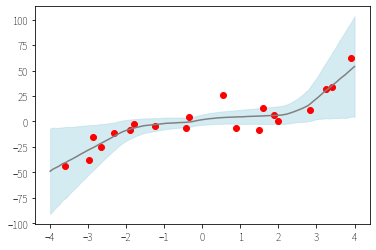

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

for network in uncertainty_methods:

    """
    Testing
    """
    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    
    
    predictions, mean, var, metrics = network.mc_predict(X_test, n_predictions)

    # Record testing end time
    toc_testing = time.time()    
    
    """
    Print results
    """
    print()
    print("Mean = " + str(mean))
    print("Variance = " + str(var))
                
    # plot mean and uncertainty
    plt.figure()
    # Actual data
    plt.plot(dataset.data_x, dataset.data_y, 'or')

    # MC prediction
    plt.plot(X_test, mean, 'gray')

    # Distributions around the predictions
    plt.fill_between(X_test.flatten(), (mean - 2*torch.sqrt(var)).flatten(), (mean + 2*torch.sqrt(var)).flatten(),
                     color='lightblue', alpha=0.5)
    
    plt.show()